# `manregress` work in progress

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [3]:
# Sample points on a torus
n = 200
xi = np.random.uniform( size = (n, 2) )

f = lambda x : np.sin( 2. * np.pi * x[0] ) * np.cos( 2. * np.pi * x[1] )

sigma = 0.1
yi = np.zeros( (n,) )
for i in range( n ):
    epsilon = np.random.normal( scale = sigma )
    yi[i] = f( xi[i] ) + epsilon

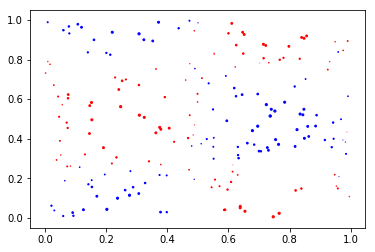

In [4]:
i_pos = (yi >= 0.)
i_neg = (yi < 0.)

vis_scale = 5.

plt.scatter( xi[i_pos, 0], xi[i_pos, 1], vis_scale * yi[i_pos], 'b' )
plt.scatter( xi[i_neg, 0], xi[i_neg, 1], vis_scale * -yi[i_neg], 'r' )

In [5]:
# Compute extra points on the manifold for distance calculations
nd = n * 30
xdi = np.random.uniform( size = (nd, 2) )

In [6]:
def embed_torus( x, r = 1., R = 3. ):
    x_embed = np.zeros( (3,) )
    x_embed[0] = ( R + r * np.cos( 2. * np.pi * x[0] ) ) * np.cos( 2. * np.pi * x[1] )
    x_embed[1] = ( R + r * np.cos( 2. * np.pi * x[0] ) ) * np.sin( 2. * np.pi * x[1] )
    x_embed[2] = r * np.sin( 2. * np.pi * x[0] )
    return x_embed

In [7]:
# Embed all points in R^3 for Euclidean graph approximation
x_all = np.r_[xi, xdi]

x_all_embed = np.zeros( (x_all.shape[0], 3) )
for i in range( x_all.shape[0] ):
    x_all_embed[i, :] = embed_torus( x_all[i, :] )

xi_embed = x_all_embed[:n, :]

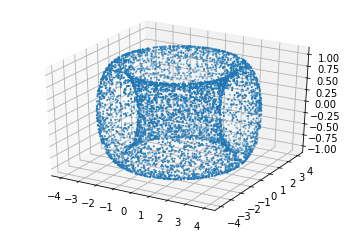

In [8]:
fig = plt.figure()
ax = fig.add_subplot( 111, projection = '3d' )
ax.scatter( x_all_embed[:, 0], x_all_embed[:, 1], x_all_embed[:, 2], s = 1 )

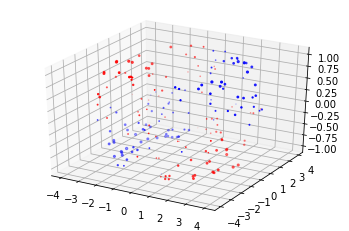

In [9]:
fig = plt.figure()
ax = fig.add_subplot( 111, projection = '3d' )
ax.scatter( xi_embed[i_pos, 0], xi_embed[i_pos, 1], xi_embed[i_pos, 2], s = vis_scale * yi[i_pos], c = 'b' )
ax.scatter( xi_embed[i_neg, 0], xi_embed[i_neg, 1], xi_embed[i_neg, 2], s = vis_scale * -yi[i_neg], c = 'r' )

In [10]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra

In [14]:
d_all = np.inf * np.ones( (x_all_embed.shape[0], x_all_embed.shape[0]) )
for i in range( d_all.shape[0] ):
    if i > 0 and i % 100 == 0:
        print( 'Row {0}'.format( i ) )
    for j in range( i, d_all.shape[1] ):
        d_all[i, j] = np.linalg.norm( x_all_embed[i, :] - x_all_embed[j, :] )

Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000
Row 1100
Row 1200
Row 1300
Row 1400
Row 1500
Row 1600
Row 1700
Row 1800
Row 1900
Row 2000
Row 2100
Row 2200
Row 2300
Row 2400
Row 2500
Row 2600
Row 2700
Row 2800
Row 2900
Row 3000
Row 3100
Row 3200
Row 3300
Row 3400
Row 3500
Row 3600
Row 3700
Row 3800
Row 3900
Row 4000
Row 4100
Row 4200
Row 4300
Row 4400
Row 4500
Row 4600
Row 4700
Row 4800
Row 4900
Row 5000
Row 5100
Row 5200
Row 5300
Row 5400
Row 5500
Row 5600
Row 5700
Row 5800
Row 5900
Row 6000
Row 6100


In [53]:
d_path = dijkstra( d_all, directed = False )

In [54]:
d_path_xi = d_path[:n, :][:, :n]

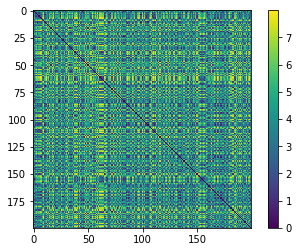

In [55]:
plt.imshow( d_path_xi, interpolation = 'none' )
plt.colorbar()

In [56]:
yi_hat = np.zeros( yi.shape )

h = 0.5

for i in range( yi.shape[0] ):
    num_cur = 0.
    denom_cur = 0.
    for j in range( d_path_xi.shape[0] ):
        k = np.exp( -(d_path_xi[i, j] * d_path_xi[i, j]) / h )
        num_cur += k * yi[j]
        denom_cur += k
    yi_hat[i] = num_cur / denom_cur

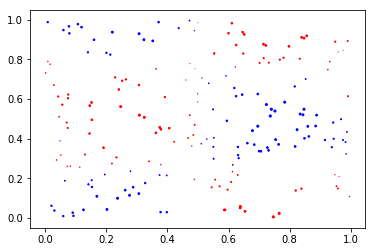

In [57]:
i_pos_hat = (yi_hat >= 0.)
i_neg_hat = (yi_hat < 0.)

plt.scatter( xi[i_pos_hat, 0], xi[i_pos_hat, 1], vis_scale * yi_hat[i_pos_hat], 'b' )
plt.scatter( xi[i_neg_hat, 0], xi[i_neg_hat, 1], vis_scale * -yi_hat[i_neg_hat], 'r' )

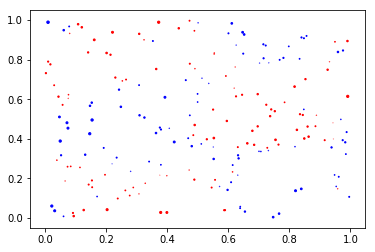

In [136]:
# yi_err = yi_hat - yi
yi_err = np.array( [yi_hat[i] - f( xi[i] ) for i in range( n )] )

i_pos_err = (yi_err >= 0.)
i_neg_err = (yi_err < 0.)

vis_scale_err = 20.

plt.scatter( xi[i_pos_err, 0], xi[i_pos_err, 1], vis_scale_err * yi_err[i_pos_err], 'b' )
plt.scatter( xi[i_neg_err, 0], xi[i_neg_err, 1], vis_scale_err * -yi_err[i_neg_err], 'r' )

In [17]:
n_est = 20
x_est = np.zeros( (n_est * n_est, 2) )
i_x = 0
for i in range( n_est ):
    for j in range( n_est ):
        x_est[i_x, 0] = i / n_est
        x_est[i_x, 1] = j / n_est
        i_x += 1

y_est = np.zeros( (x_est.shape[0],) )

h = 0.5

for i in range( x_est.shape[0] ):
    
    if i > 0 and i % 20 == 0:
        print( 'Point {0} of {1}'.format( i, x_est.shape[0] ) )
    
    num_cur = 0.
    denom_cur = 0.
    
    x_cur = x_est[i, :]
    x_cur_embed = embed_torus( x_cur )
    
    d_cur = np.zeros( (x_all_embed.shape[0] + 1,) )
    for j in range( x_all_embed.shape[0] ):
        d_cur[j+1] = np.linalg.norm( x_cur_embed - x_all_embed[j, :] )
    d_cur_all = np.zeros( (d_all.shape[0] + 1, d_all.shape[1] + 1) )
    d_cur_all[1:, 1:] = d_all
    d_cur_all[0, :] = d_cur
    
    d_path_cur = dijkstra( d_cur_all, indices = 0, directed = False )
    d_path_cur_xi = d_path_cur[1:(n+1)]
    
    for j in range( d_path_cur_xi.shape[0] ):
        k = np.exp( -(d_path_cur_xi[j] * d_path_cur_xi[j]) / h )
        num_cur += k * yi[j]
        denom_cur += k
    y_est[i] = num_cur / denom_cur

Point 20 of 400
Point 40 of 400
Point 60 of 400
Point 80 of 400
Point 100 of 400
Point 120 of 400
Point 140 of 400
Point 160 of 400
Point 180 of 400
Point 200 of 400
Point 220 of 400
Point 240 of 400
Point 260 of 400
Point 280 of 400
Point 300 of 400
Point 320 of 400
Point 340 of 400
Point 360 of 400
Point 380 of 400


In [18]:
y_est_grid = np.zeros( (n_est, n_est) )
i_x = 0
for i in range( n_est ):
    for j in range( n_est ):
        y_est_grid[i, j] = y_est[i_x]
        i_x += 1

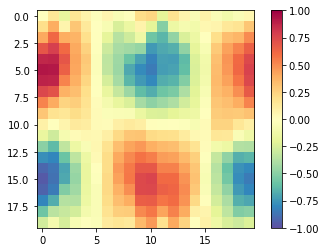

In [19]:
plt.imshow( y_est_grid )
plt.set_cmap( 'Spectral_r' )
plt.clim( -1, 1 )
plt.colorbar()

## Local linear regression using tangent spaces

In [15]:
d_all_symmetric = np.zeros( d_all.shape )
for i in range( d_all_symmetric.shape[0] ):
    for j in range( d_all_symmetric.shape[1] ):
        if j >= i:
            d_all_symmetric[i, j] = d_all[i, j]
        if j < i:
            d_all_symmetric[i, j] = d_all[j, i]

In [16]:
local_d_limit = 0.5

d_all_symmetric_local = np.zeros( d_all_symmetric.shape )
for i in range( d_all_symmetric_local.shape[0] ):
    for j in range( d_all_symmetric_local.shape[1] ):
        if d_all_symmetric[i, j] < local_d_limit:
            d_all_symmetric_local[i, j] = d_all_symmetric[i, j]
        else:
            d_all_symmetric_local[i, j] = np.inf

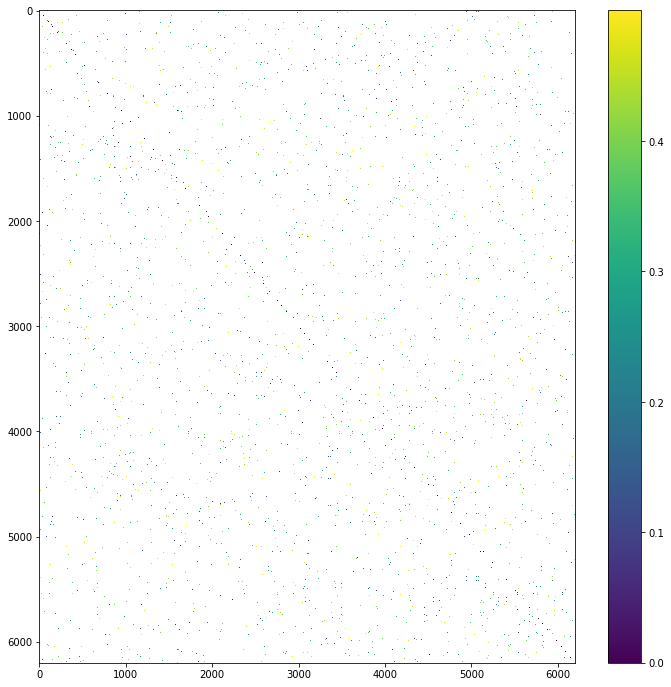

In [17]:
plt.figure( figsize = (12, 12) )
plt.imshow( d_all_symmetric_local, aspect = 'auto' )
# plt.imshow( d_all, aspect = 'auto' )
plt.set_cmap( 'viridis' )
plt.colorbar()
plt.show()

In [18]:
d_path, predecessors_path = dijkstra( d_all_symmetric_local,
                                      directed = False,
                                      return_predecessors = True )

In [19]:
def get_path( p, i, j ):
    ret = [j]
    j_cur = j
    while True:
        predecessor_cur = p[i, j_cur]
        if predecessor_cur == i:
            break
        if predecessor_cur < 0:
            return None
        
        j_next = predecessor_cur
        ret.append( j_next )
        j_cur = j_next
    ret.append( i )
    return ret

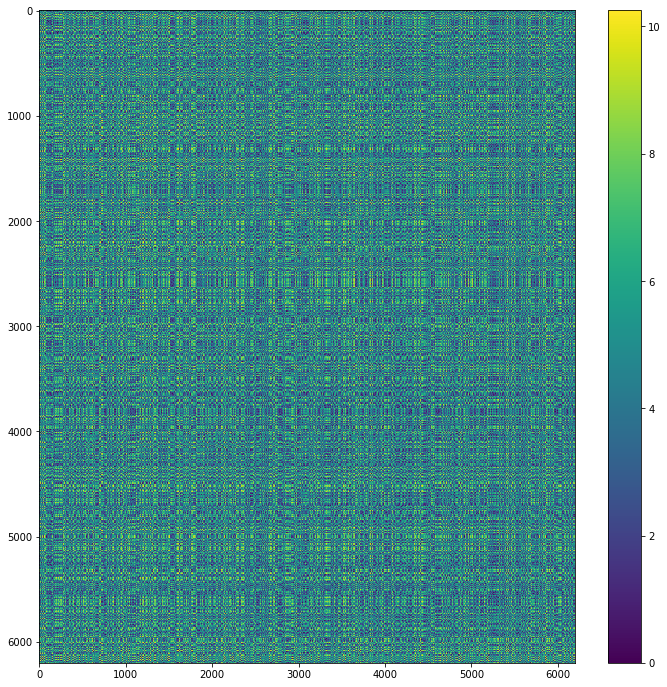

In [20]:
plt.figure( figsize = (12, 12) )
# plt.imshow( np.multiply( d_all_symmetric, d_all_symmetric < 0.5 ), aspect = 'auto' )
plt.imshow( d_path, aspect = 'auto' )
plt.set_cmap( 'viridis' )
plt.colorbar()
plt.show()

In [24]:
print( get_path( predecessors_path, 10, 100 ) )
print( get_path( predecessors_path, 100, 10 )[::-1] )

[100, 4295, 3352, 4116, 855, 4418, 3268, 3737, 1935, 155, 1442, 1495, 6002, 2066, 2834, 2090, 1034, 547, 2425, 3934, 10]
[100, 4295, 3352, 4116, 855, 4418, 3268, 3737, 1935, 155, 1442, 1495, 6002, 2066, 2834, 2090, 1034, 547, 2425, 3934, 10]


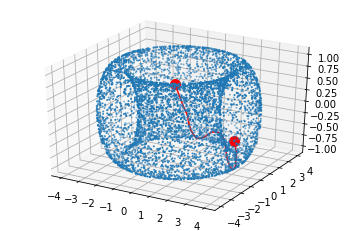

In [179]:
fig = plt.figure()
ax = fig.add_subplot( 111, projection = '3d' )
ax.scatter( x_all_embed[:, 0], x_all_embed[:, 1], x_all_embed[:, 2], s = 1 )

node_start = 310
node_end = 1001

ax.plot( np.array( [x_all_embed[node_start, 0], x_all_embed[node_end, 0]] ),
         np.array( [x_all_embed[node_start, 1], x_all_embed[node_end, 1]] ),
         np.array( [x_all_embed[node_start, 2], x_all_embed[node_end, 2]] ),
         'r.',
         markersize = 20 )

cur_path = get_path( predecessors_path, node_start, node_end )
for i_step, _ in enumerate( cur_path ):
    if i_step >= len( cur_path ) - 1:
        break
    cur_start = cur_path[i_step]
    cur_end = cur_path[i_step + 1]
    
    ax.plot( np.array( [x_all_embed[cur_start, 0], x_all_embed[cur_end, 0]] ),
             np.array( [x_all_embed[cur_start, 1], x_all_embed[cur_end, 1]] ),
             np.array( [x_all_embed[cur_start, 2], x_all_embed[cur_end, 2]] ),
             'r-' )

plt.show()

In [41]:
import statsmodels.api as sm
from tqdm import tqdm

In [44]:
i_base = 2000
x_base = x_all[i_base, :]

x_regress = np.zeros( (n, 2) )

for i_target in range( n ):
    
    cur_path = get_path( predecessors_path, i_base, i_target )[::-1]
    i_next = cur_path[1]
    x_next_raw = x_all[i_next, :]
    x_next_center = x_next_raw - x_base
    
    d_cur = d_path[i_base, i_target]
    d_next = d_path[i_base, i_next]
    t_cur = d_next / d_cur
    
    x_regress[i_target, :] = x_next_center / t_cur
    
    x_regress_full = sm.add_constant( x_regress )

In [47]:
ols = sm.OLS( yi, x_regress_full )
res = ols.fit()
print( res.summary() )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3255
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.723
Time:                        11:51:16   Log-Likelihood:                -146.57
No. Observations:                 200   AIC:                             299.1
Df Residuals:                     197   BIC:                             309.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0588      0.057      1.029      0.3

In [51]:
print( ols.predict( res.params, np.array( [1, 0, 0] ) ) )

0.05881327272734911


In [87]:
def K( x1, x2, h = 0.5 ):
    d = x1.shape[0]
    return np.power( h, d ) * np.exp( -( np.power( np.linalg.norm( x2 - x1 ), 2. ) ) / h )

In [160]:
yi_hat_linear = np.zeros( (n,) )

d = x_all.shape[1]

for i_base in tqdm( range( n ) ):
    
    x_base = x_all[i_base, :]
    
    i_counter = 0
    x_regress = np.zeros( (n - 1, 2) )
    y_regress = np.zeros( (n - 1,) )
    w_regress = np.zeros( (n - 1,) )
    
    for i_target in range( n ):
        
        if i_base == i_target:
            continue
            
        cur_path = get_path( predecessors_path, i_base, i_target )[::-1]
        i_next = cur_path[1]
        x_next_raw = x_all[i_next, :]
        x_next_center = x_next_raw - x_base

        d_cur = d_path[i_base, i_target]
        d_next = d_path[i_base, i_next]
        t_cur = d_next / d_cur

        x_regress[i_counter, :] = x_next_center * (1. / t_cur)
        y_regress[i_counter] = yi[i_target]
        w_regress[i_counter] = K( x_regress[i_counter, :], np.zeros( (d,) ), h = 0.005 )
        
        i_counter += 1

    x_regress_full = sm.add_constant( x_regress )
    wls = sm.WLS( y_regress, x_regress_full, weights = w_regress )
    res = wls.fit()

    yi_hat_linear[i_base] = wls.predict( res.params, np.array( [1, 0, 0] ) )

100%|██████████| 200/200 [00:02<00:00, 67.55it/s]


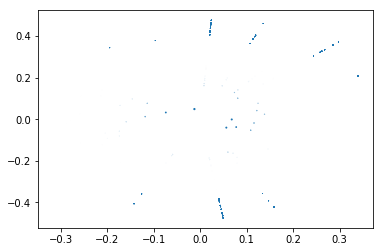

In [161]:
plt.scatter( x_regress_full[:, 1], x_regress_full[:, 2], s = 100000. * w_regress )

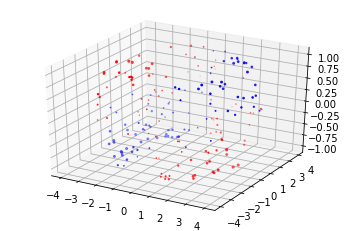

In [171]:
i_pos = (yi_hat_linear >= 0.)
i_neg = (yi_hat_linear < 0.)

fig = plt.figure()
ax = fig.add_subplot( 111, projection = '3d' )
vis_scale = 5
ax.scatter( xi_embed[i_pos, 0], xi_embed[i_pos, 1], xi_embed[i_pos, 2], s = vis_scale * yi_hat_linear[i_pos], c = 'b' )
ax.scatter( xi_embed[i_neg, 0], xi_embed[i_neg, 1], xi_embed[i_neg, 2], s = vis_scale * -yi_hat_linear[i_neg], c = 'r' )

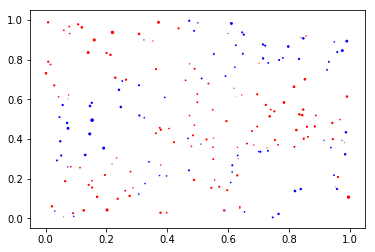

In [163]:
# yi_err_linear = yi_hat_linear - yi
yi_err_linear = np.array( [yi_hat_linear[i] - f( xi[i] ) for i in range( n )] )

i_pos_err = (yi_err_linear >= 0.)
i_neg_err = (yi_err_linear < 0.)

vis_scale_err = 20.

plt.scatter( xi[i_pos_err, 0], xi[i_pos_err, 1], vis_scale_err * yi_err_linear[i_pos_err], 'b' )
plt.scatter( xi[i_neg_err, 0], xi[i_neg_err, 1], vis_scale_err * -yi_err_linear[i_neg_err], 'r' )

In [164]:
print( 'NW squared error: {0}'.format( np.sum( yi_err * yi_err ) ) )
print( 'LL squared error: {0}'.format( np.sum( yi_err_linear * yi_err_linear ) ) )

NW squared error: 1.8931614504165442
LL squared error: 1.4521984059512425


## Use leave-one-out CV to determine which system has better optimal performance